In [ ]:
# 📦 Imports y carga de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

# Cargar dataset
df = pd.read_csv("../dataset/F1_Datos_limpios.csv")

C:\Users\salva\AppData\Local\Temp\ipykernel_14964\1671778760.py:14: DtypeWarning: Columns (6,28,41,46,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../dataset/F1_Datos_limpios.csv")


In [44]:
# 🎯 Selección de features y target
features = [
    'grid','avg_grid', 'avg_position_change', 'avg_real_points', 'avg_position',
    'races', 'wins', 'dnfs','win_rate', 'dnf_rate', 'constructorId', 'driverId', 'circuitId', 'circuit_type', 'avg_gap_to_leader', 'avg_gap_to_team', 'circuit_prev_races',
    'circuit_prev_dnfs','circuit_prev_wins','circuit_prev_avg_pos','circuit_prev_avg_points','circuit_prev_dnf_rate','circuit_prev_win_rate',
    'last_n_avg_position', 'last_n_total_points', 'last_n_wins', 'last_n_dnfs', 'last_n_avg_grid', 'last_n_avg_gap_to_leader', 'last_n_avg_gap_to_team', 'last_n_avg_position_change',
    'temperature_C', 'precipitation_mm', 'wind_speed_kmh', 'humidity_pct', 'isRainy', 'race_year', 'race_month', 'race_day', 'race_hour', 'driver_age'
]
target = 'positionOrder'

# Filtrado y limpiezaimpieza
df_original = df.copy()
df = df[features + [target]].dropna()
X = df[features]
y = df[target]


In [45]:
# 🧠 Codificación y balanceo con SMOTE
X = pd.get_dummies(X, drop_first=True)

# Balanceo de clases
sm = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = sm.fit_resample(X, y)

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)


In [46]:
#ZeroR para comparación
from sklearn.dummy import DummyRegressor
zeroR = DummyRegressor(strategy='mean')
zeroR.fit(X_train, y_train)

DummyRegressor()

In [47]:
# 🌲 Árbol de regresion
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
y_pred_tree_rounded = np.round(y_pred_tree).astype(int)
print("Decision Tree Regressor:")
print("R^2 Score:", tree.score(X_test, y_test))

Decision Tree Regressor:
R^2 Score: 0.1670771330907881


In [48]:
# 🌳 RandomForest
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)
print("Random Forest Regressor:")
print("R^2 Score:", forest.score(X_test, y_test))


Random Forest Regressor:
R^2 Score: 0.6080155651736179


In [49]:
# ⚡ XGBoost
xgb = XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_rounded = np.round(y_pred_xgb).astype(int)
print("XGBoost Regressor:")
print("R^2 Score:", xgb.score(X_test, y_test))


c:\Users\salva\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:14:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Regressor:
R^2 Score: 0.5795369148254395


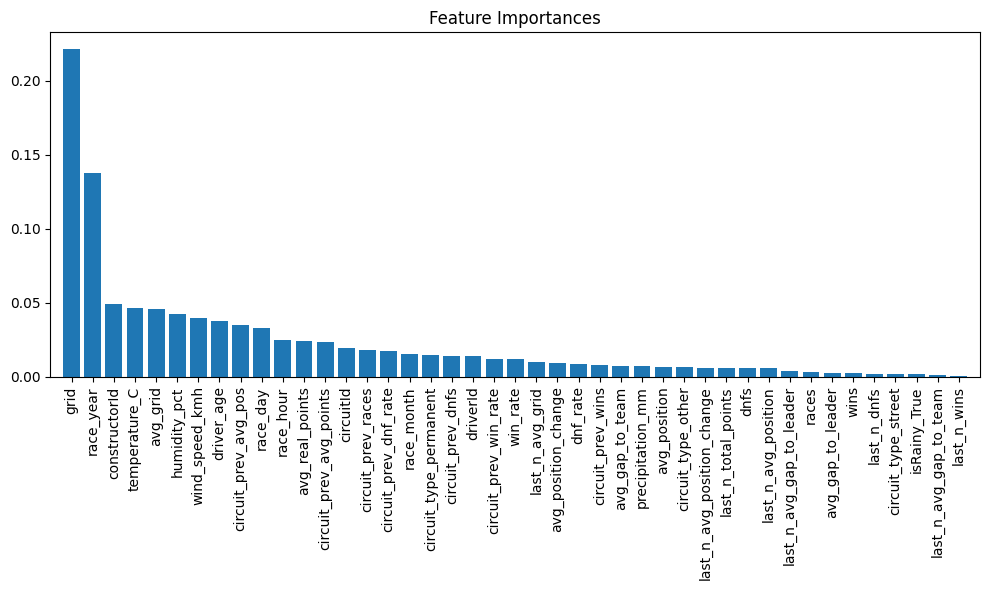

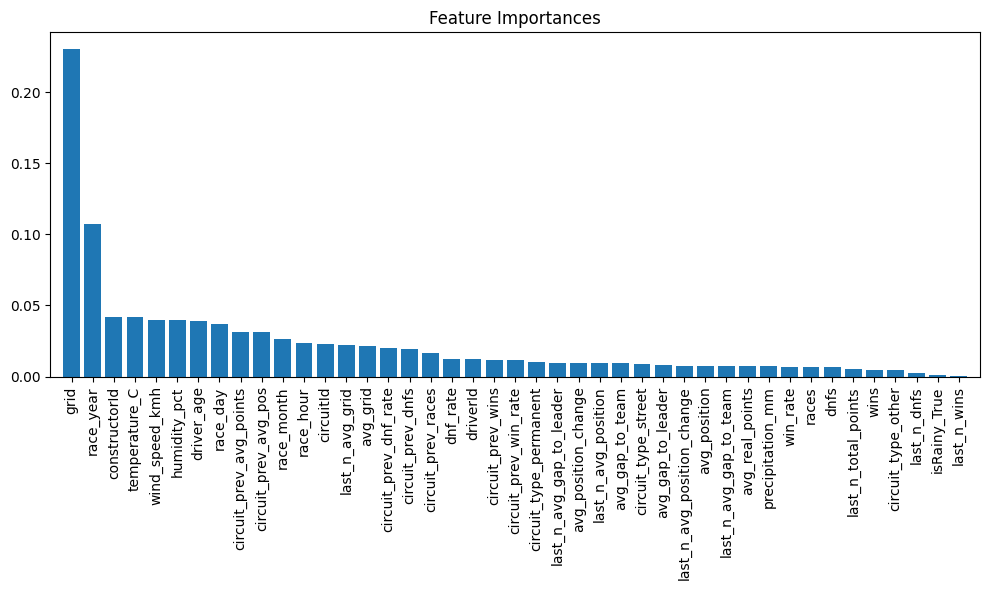

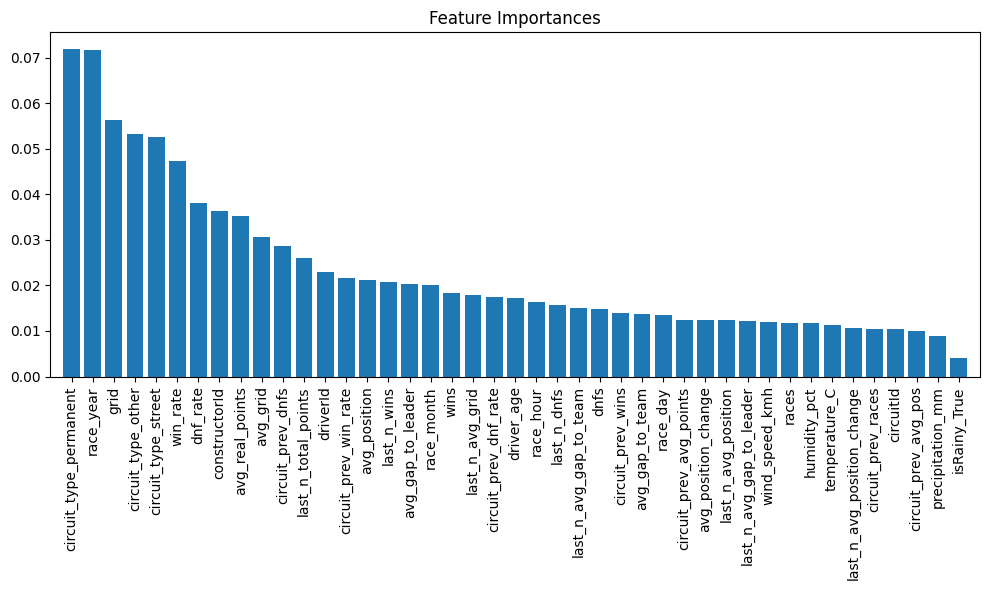

In [50]:
# graficas de los modelos regresores
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()
plot_feature_importances(tree, X_train.columns)
plot_feature_importances(forest, X_train.columns)
plot_feature_importances(xgb, X_train.columns)

In [51]:
# Evaluación de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Evaluación de ZeroR
mae_zeroR, mse_zeroR, r2_zeroR = evaluate_model(zeroR, X_test, y_test)
# Evaluación de Decision Tree
mae_tree, mse_tree, r2_tree = evaluate_model(tree, X_test, y_test)
# Evaluación de Random Forest
mae_forest, mse_forest, r2_forest = evaluate_model(forest, X_test, y_test)
# Evaluación de XGBoost
mae_xgb, mse_xgb, r2_xgb = evaluate_model(xgb, X_test, y_test)
# Resultados de evaluación
results = pd.DataFrame({
    'Model': ['ZeroR', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [mae_zeroR, mae_tree, mae_forest, mae_xgb],
    'MSE': [mse_zeroR, mse_tree, mse_forest, mse_xgb],
    'R^2': [r2_zeroR, r2_tree, r2_forest, r2_xgb]
})
print("\nModel Evaluation Results:")
print(results)

# el MAE es el error absoluto medio, que mide la media de los errores absolutos entre las predicciones y los valores reales.
# el MSE es el error cuadrático medio, que mide la media de los errores al cuadrado entre las predicciones y los valores reales.
# el R^2 es el coeficiente de determinación, que mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes.


Model Evaluation Results:
           Model       MAE        MSE       R^2
0          ZeroR  5.999571  47.902361 -0.000005
1  Decision Tree  4.105536  39.898789  0.167077
2  Random Forest  3.362496  18.776894  0.608016
3        XGBoost  3.392554  20.141081  0.579537


C:\Users\salva\AppData\Local\Temp\ipykernel_14964\2242096042.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results, palette='viridis')


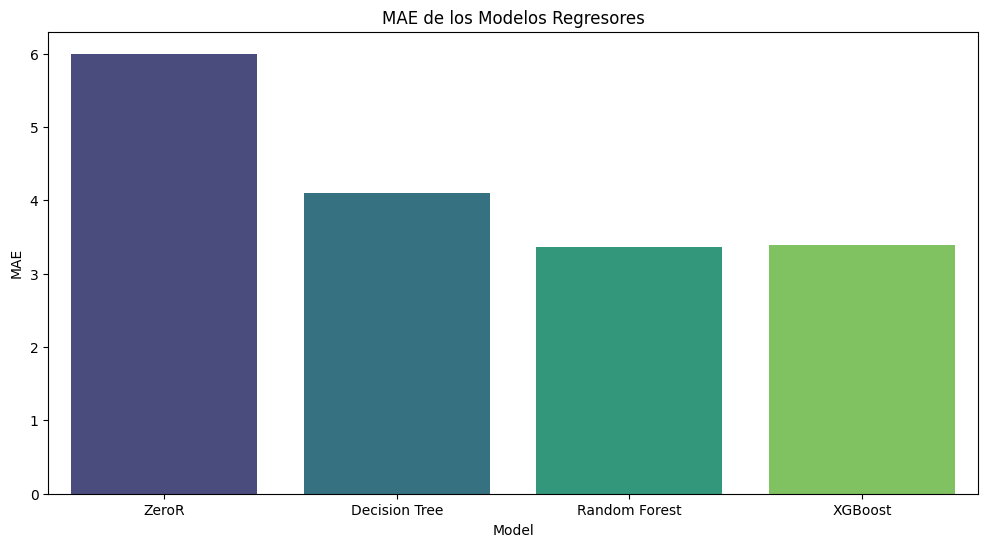

C:\Users\salva\AppData\Local\Temp\ipykernel_14964\2242096042.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=results, palette='viridis')


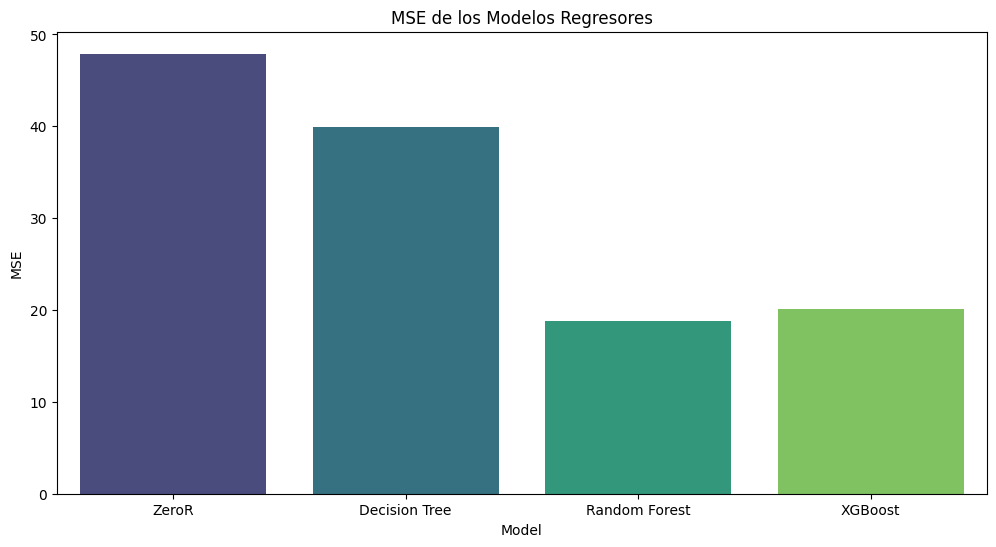

C:\Users\salva\AppData\Local\Temp\ipykernel_14964\2242096042.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R^2', data=results, palette='viridis')


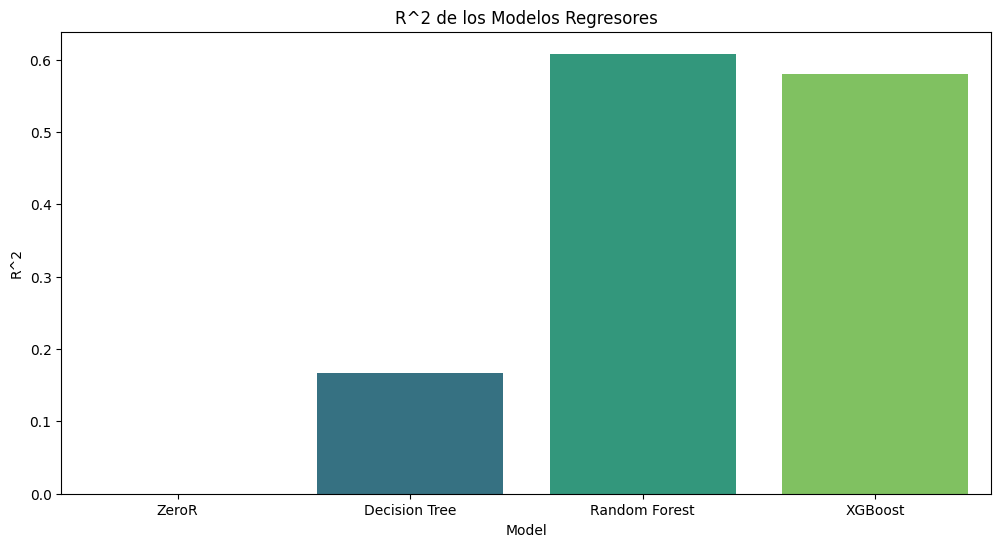

In [52]:
# graficas de los modelos regresores usando results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', data=results, palette='viridis')
plt.title('MAE de los Modelos Regresores')
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MSE', data=results, palette='viridis')
plt.title('MSE de los Modelos Regresores')
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R^2', data=results, palette='viridis')
plt.title('R^2 de los Modelos Regresores')
plt.show()

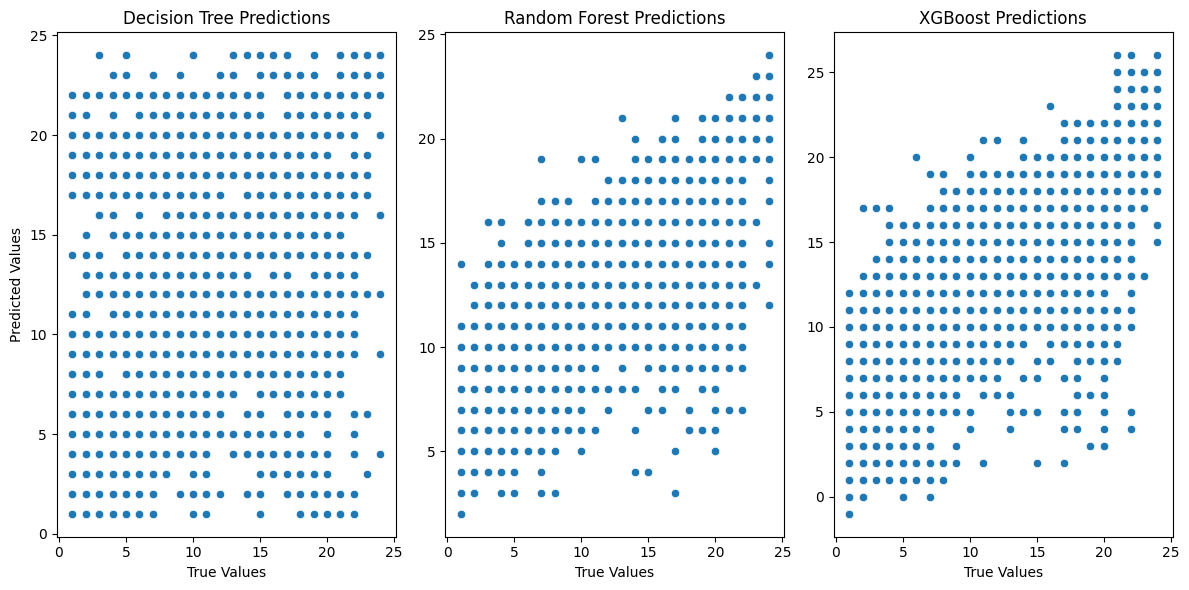

In [53]:
#graficas de comparacion de los modelos
def plot_model_comparison(y_true, y_pred_tree, y_pred_forest, y_pred_xgb):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_true, y=y_pred_tree)
    plt.title("Decision Tree Predictions")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=y_true, y=y_pred_forest)
    plt.title("Random Forest Predictions")
    plt.xlabel("True Values")
    
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=y_true, y=y_pred_xgb)
    plt.title("XGBoost Predictions")
    plt.xlabel("True Values")
    
    plt.tight_layout()
    plt.show()
plot_model_comparison(y_test, y_pred_tree_rounded, y_pred_rounded, y_pred_xgb_rounded)




In [54]:
def predecir_posicion(modelo, df_original, filtro, features):
    # Filtramos las filas específicas
    df_filtrado = df_original.query(filtro).copy()

    if df_filtrado.empty:
        print("⚠️ No se encontraron filas con ese filtro.")
        return

    X_filtrado = df_filtrado[features]
    # Aplicar la misma codificación one-hot que en entrenamiento
    X_filtrado_encoded = pd.get_dummies(X_filtrado, drop_first=True)
    # Alinear columnas con las del entrenamiento (X_train)
    X_filtrado_encoded = X_filtrado_encoded.reindex(columns=X_train.columns, fill_value=0)

    predicciones = modelo.predict(X_filtrado_encoded)
    probabilidades = modelo.predict_proba(X_filtrado_encoded)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Mostramos resultados
    df_filtrado_resultado = df_filtrado.copy()
    df_filtrado_resultado['prediccion_position'] = predicciones

    return df_filtrado_resultado

In [55]:
#graficar diferencia entre positionOrder y predicciondef 

def graficar_diferencia_position(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['positionOrder'], df['prediccion_position'], alpha=0.5)
    plt.plot([df['positionOrder'].min(), df['positionOrder'].max()], [df['positionOrder'].min(), df['positionOrder'].max()], color='red', linestyle='--')
    plt.title('Diferencia entre Position y Predicción')
    plt.xlabel('Position Real')
    plt.ylabel('Predicción de Position')
    plt.grid()
    plt.show()


🔎 Predicciones de posicion para: Decision Tree


,raceId,year,circuitRef,driverRef,constructorRef,positionOrder,prediccion_position
23216,1040,2020,sochi,bottas,mercedes,1,1.0
23217,1040,2020,sochi,max_verstappen,red_bull,2,2.0
23218,1040,2020,sochi,hamilton,mercedes,3,3.0
23219,1040,2020,sochi,perez,racing_point,4,1.0
23220,1040,2020,sochi,ricciardo,renault,5,8.0
23221,1040,2020,sochi,leclerc,ferrari,6,10.0
23222,1040,2020,sochi,ocon,renault,7,10.0
23223,1040,2020,sochi,kvyat,alphatauri,8,8.0
23224,1040,2020,sochi,gasly,alphatauri,9,11.0
23225,1040,2020,sochi,albon,red_bull,10,14.0


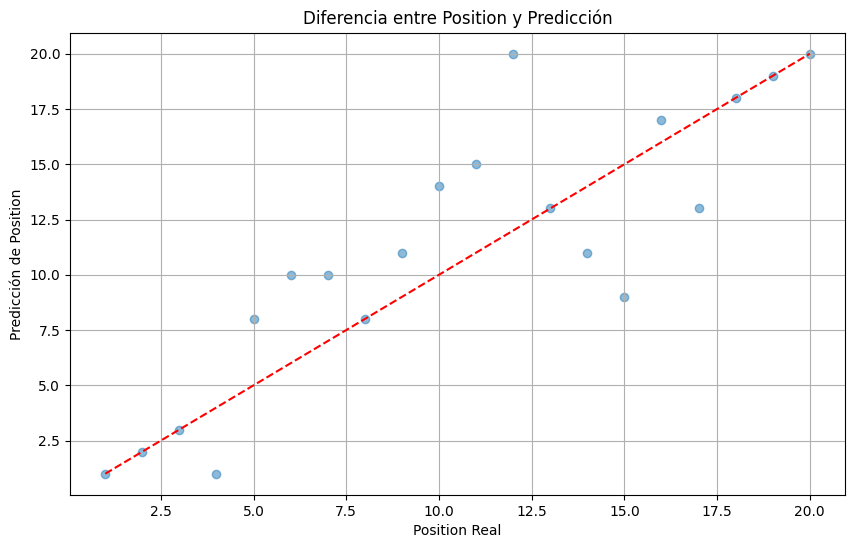

🔎 Predicciones de posicion para: Random Forest


,raceId,year,circuitRef,driverRef,constructorRef,positionOrder,prediccion_position
23216,1040,2020,sochi,bottas,mercedes,1,2.98
23217,1040,2020,sochi,max_verstappen,red_bull,2,2.18
23218,1040,2020,sochi,hamilton,mercedes,3,3.15
23219,1040,2020,sochi,perez,racing_point,4,5.89
23220,1040,2020,sochi,ricciardo,renault,5,7.81
23221,1040,2020,sochi,leclerc,ferrari,6,12.29
23222,1040,2020,sochi,ocon,renault,7,8.60
23223,1040,2020,sochi,kvyat,alphatauri,8,9.75
23224,1040,2020,sochi,gasly,alphatauri,9,10.81
23225,1040,2020,sochi,albon,red_bull,10,13.45


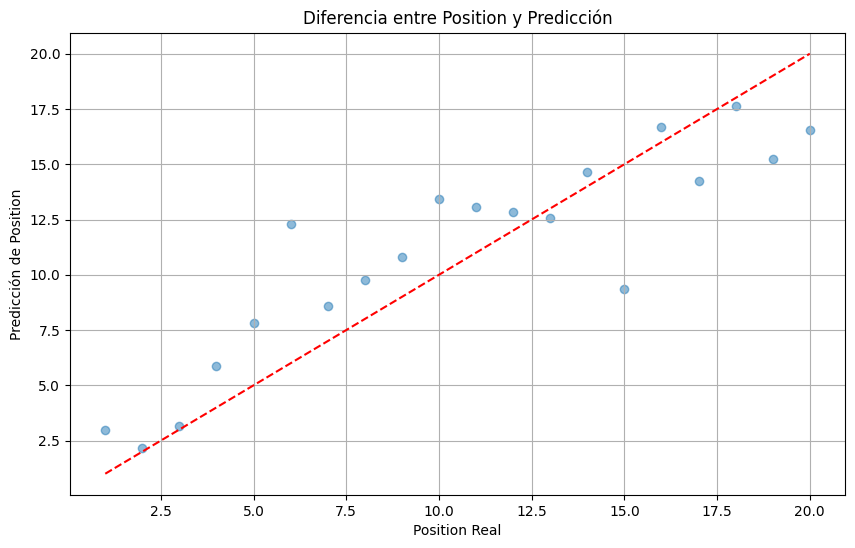

🔎 Predicciones de posicion para: XGBoost


,raceId,year,circuitRef,driverRef,constructorRef,positionOrder,prediccion_position
23216,1040,2020,sochi,bottas,mercedes,1,1.396140
23217,1040,2020,sochi,max_verstappen,red_bull,2,2.377646
23218,1040,2020,sochi,hamilton,mercedes,3,2.683588
23219,1040,2020,sochi,perez,racing_point,4,5.738402
23220,1040,2020,sochi,ricciardo,renault,5,6.900401
23221,1040,2020,sochi,leclerc,ferrari,6,15.364538
23222,1040,2020,sochi,ocon,renault,7,10.283910
23223,1040,2020,sochi,kvyat,alphatauri,8,10.520332
23224,1040,2020,sochi,gasly,alphatauri,9,11.447552
23225,1040,2020,sochi,albon,red_bull,10,5.669683


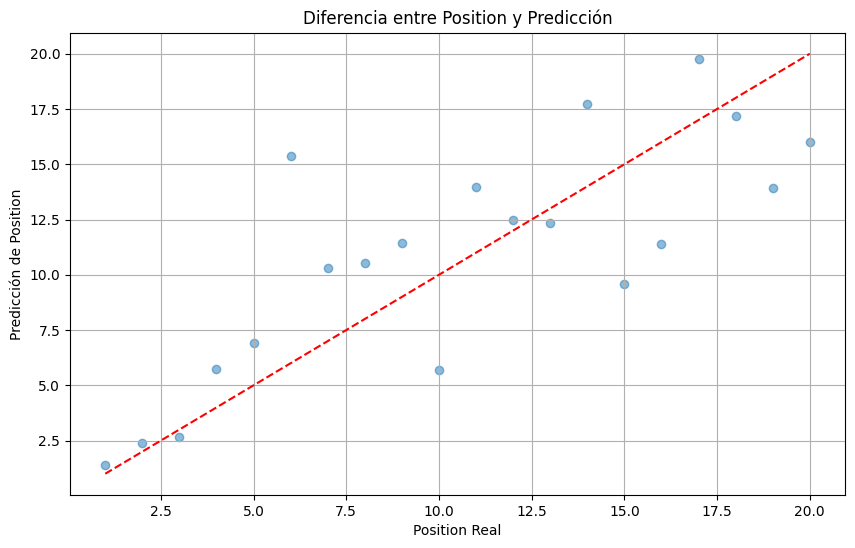

In [56]:
filtro = "raceId == 1040"

# Para el árbol de decisión
df_decision_tree = predecir_posicion(tree, df_original, filtro, features)
print(f"🔎 Predicciones de posicion para: Decision Tree")
display(df_decision_tree.sort_values('positionOrder')[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'positionOrder', 'prediccion_position']])
graficar_diferencia_position(df_decision_tree)

# Para probar con el modelo de Random Forest
df_random_forest = predecir_posicion(forest, df_original, filtro, features)
print(f"🔎 Predicciones de posicion para: Random Forest")
display(df_random_forest.sort_values('positionOrder')[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'positionOrder', 'prediccion_position']])
graficar_diferencia_position(df_random_forest)

# Para XGBoost
df_xgboost = predecir_posicion(xgb, df_original, filtro, features)
print(f"🔎 Predicciones de posicion para: XGBoost")
display(df_xgboost.sort_values('positionOrder')[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'positionOrder', 'prediccion_position']])
graficar_diferencia_position(df_xgboost)
